In [48]:
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl

In [49]:
# # from coffea casa
# import uproot
# f = uproot.open('root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/250000/13D6BBD5-89E3-8647-AED6-FB5DFAAF4C8C.root:Events')
# f.num_entries   ### checks number of events

In [50]:
# import uproot
# sample = "GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"
# for i in range(len(fileset[sample])):
#     f = uproot.open(fileset[sample][i])
#     num = f['Events'].num_entries   ### checks number of events per file        
#     print('number of events in file', i, 'is', num)

In [94]:
### load result of 2 jobs
sample = 'GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8'
year = '2017'
num_jobs = 2
sum_sumgenweight = {}
sum_sumgenweight[sample] = 0
channels = ['ele', 'mu', 'had']
data_all = {}


for ch in channels:
    for i in range(num_jobs):
        tmp = pq.read_table(f'./outfiles/{i}-{i+1}_{ch}.parquet')
        tmp = tmp.to_pandas()
        if i==0:
            data = tmp
        else:
            data = pd.concat([data,tmp], ignore_index=True)

    data_all[ch] = data    
    # load and sum the sumgenweight of each
    with open(f'./outfiles/{i}-{i+1}.pkl', 'rb') as f:
        metadata = pkl.load(f)
    sum_sumgenweight[sample] = sum_sumgenweight[sample] + metadata[sample][year]['sumgenweight']

In [99]:
data_all.keys()

dict_keys(['ele', 'mu', 'had'])

In [66]:
xsec = {}
xsec[sample] = 2

luminosity = {}
luminosity[year] = 3

xsec_weight = {}
xsec_weight[sample] = (xsec[sample] * luminosity[year])/ (sum_sumgenweight[sample])

## Make histograms

In [103]:
### for leptonic channel
leppt = {}
for ch in ['ele', 'mu']:
    leppt[ch] = data_all[ch]['lepton_pt'].to_numpy()

In [106]:
# now we can make histograms for higgspt, jetpt, leptonpt
import hist as hist2
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)

leppt_axis = hist2.axis.Regular(25, 10, 400, name='leppt', label=r'Lepton $p_T$ [GeV]')

hists = {}
hists = hist2.Hist(
                channel_cat,
                leppt_axis,
            )

hists.fill(
    channel="ele",
    leppt=leppt['ele'],
)
hists.fill(
    channel="mu",
    leppt=leppt['mu'],
)
hists

Hist(
  StrCategory(['ele', 'mu'], growth=True, name='channel', label='channel'),
  Regular(25, 10, 400, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 1899.0 (1902.0 with flow)

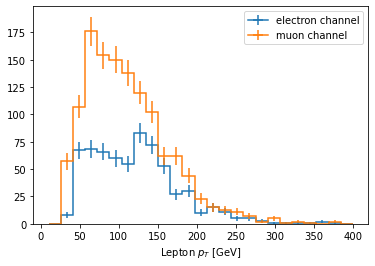

In [113]:
# now we plot trigger efficiency as function of jetpt
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(hists[{"channel":"ele"}], 
             # yerr=get_yerr(num_nom),
             ax = ax,
             # weight = sum_sumgenweight[sample],
             # histtype='errorbar', color='red', capsize=4, elinewidth=1, 
             label="electron channel",
)
hep.histplot(hists[{"channel":"mu"}], 
             # yerr=get_yerr(num_nom),
             ax = ax,
             # weight = sum_sumgenweight[sample],
             # histtype='errorbar', color='red', capsize=4, elinewidth=1, 
             label="muon channel",
)
# ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/ele_triggers/lol.pdf');